## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

## Read Train Data

In [3]:
dataset = pd.read_csv('train.csv')

In [4]:
dataset.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
 #   Column           Dtype  
---  ------           -----  
 0   acoustic_data    int64  
 1   time_to_failure  float64
dtypes: float64(1), int64(1)
memory usage: 9.4 GB


In [6]:
df = dataset.copy()

In [7]:
df

,acoustic_data,time_to_failure
0,12,1.469100
1,6,1.469100
2,8,1.469100
3,5,1.469100
4,8,1.469100
...,...,...
629145475,7,9.759796
629145476,9,9.759796
629145477,10,9.759796
629145478,6,9.759796


## EDA

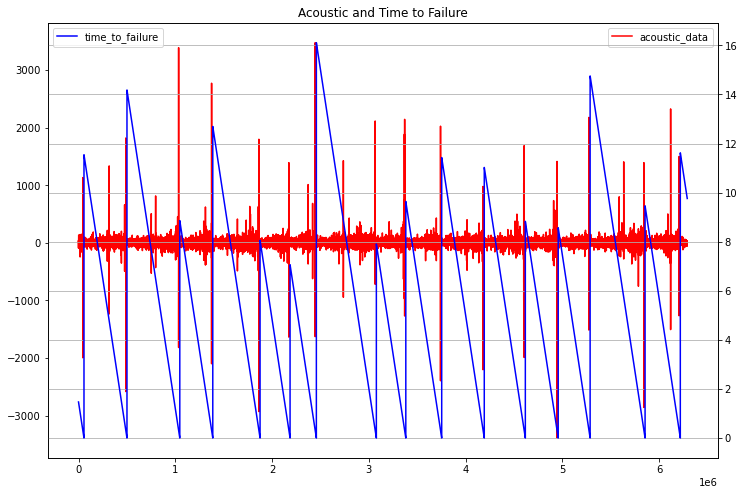

In [33]:
fig, axes1 = plt.subplots(figsize=(12,8))

plt.title('Acoustic and Time to Failure')
axes1.plot(df['acoustic_data'].values[::100], color='r', label='acoustic_data')
axes1.legend(loc=1)

axes2 = axes1.twinx()
axes2.plot(df['time_to_failure'].values[::100], color='b', label='time_to_failure')
axes2.legend(loc=2)

plt.grid(True)

In [42]:
def generate_featues(X):
    features = list()
    features.append(X.mean())
    features.append(X.std())
    features.append(X.skew())
    features.append(X.kurtosis())
    features.append(X.min())
    features.append(np.quantile(X, 0.01))
    return pd.Series(features)

In [64]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150000)

### CatBoost

In [44]:
X_train = pd.DataFrame()
y_train = pd.Series()
for data in train:
    new_features = generate_featues(data['acoustic_data'])
    X_train = X_train.append(new_features, ignore_index=True)
    y_train = y_train.append(pd.Series(data['time_to_failure'].values[-1]))

C:\Users\Eashan\AppData\Local\Temp/ipykernel_20668/3572406227.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train = pd.Series()


In [84]:
from catboost import Pool, CatBoostRegressor

train_pool = Pool(X_train, y_train)
model = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
model.fit(X_train, y_train, silent=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [87]:
model.best_score_

{'learn': {'MAE': 1.463164590962654}}

In [88]:
import os

In [95]:
test_dir = os.listdir('test')

X_test = pd.DataFrame()

for file in test_dir:
    test = pd.read_csv('test/' + file)
    new_features = generate_featues(test['acoustic_data'])

    X_test = X_test.append(new_features, ignore_index=True)

In [106]:
y_test = model.predict(X_test)

In [117]:
test_dir = [d.split('.')[0] for d in test_dir]

In [118]:
sample = pd.DataFrame({'seg_id': pd.Series(test_dir), 'time_to_failure': pd.Series(y_test)})

In [119]:
sample.to_csv('sample.csv', index=False)

### SVM

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)